# Noise Detection Evaluation Benchmark

This notebook builds and evaluates four noise detection heuristics on a synthetic benchmark using publicly available datasets.

## Overview
1. **Data Preparation**: Mix clean speech and noise at varying SNR levels.
2. **Detection Heuristics**:
   - Low Speech Ratio (VAD)
   - Spectral Flatness & Zero-Crossing Rate
   - RMS Threshold
   - STT Confidence (Whisper)
3. **Evaluation**: Compute ROC curves and AUC for each method.


In [25]:
# Imports and Configuration
import os
import logging
from pathlib import Path

import numpy as np
import soundfile as sf
import librosa
import webrtcvad
from faster_whisper import WhisperModel
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(level=logging.WARNING, format='%(asctime)s %(levelname)s: %(message)s')

# Directories (Please download datasets manually into these folders)
CLEAN_DIR = Path('data/clean_speech')  # e.g., CHiME-4 or VoiceBank-DEMAND clean speech
NOISE_DIR = Path('data/noise')        # e.g., MUSAN noise files
MIXED_DIR = Path('data/mixed')
MIXED_DIR.mkdir(parents=True, exist_ok=True)

# SNR levels for mixing (in dB)
SNR_LEVELS = [-5, 0, 5, 10, 15, 20]


In [3]:
def scale_noise(clean: np.ndarray, noise: np.ndarray, snr_db: float) -> np.ndarray:
    """Scale noise to achieve desired SNR relative to clean signal."""
    clean_rms = np.sqrt(np.mean(clean**2))
    noise_rms = np.sqrt(np.mean(noise**2)) + 1e-8
    target_noise_rms = clean_rms / (10**(snr_db / 20))
    return noise * (target_noise_rms / noise_rms)

def mix_with_noise(clean_path: Path, noise_path: Path, snr_db: float, out_path: Path):
    """Mix a clean file with noise at given SNR and save to out_path."""
    clean, sr = sf.read(clean_path)
    noise, _ = sf.read(noise_path)
    # Ensure noise is at least as long as clean
    if len(noise) < len(clean):
        repeats = int(np.ceil(len(clean) / len(noise)))
        noise = np.tile(noise, repeats)
    noise = noise[:len(clean)]
    scaled_noise = scale_noise(clean, noise, snr_db)
    mixture = clean + scaled_noise
    sf.write(out_path, mixture, sr)


In [6]:
from random import sample

# Limit number of files for faster testing
NUM_CLEAN = 20
# Filter and sample files
all_clean_files = list(CLEAN_DIR.glob("*.wav"))
all_noise_files = [f for f in NOISE_DIR.glob("*.wav") if "white" in f.stem.lower()]

clean_files = sample(all_clean_files, min(NUM_CLEAN, len(all_clean_files)))
noise_files = all_noise_files  # use all matching "white" noise files

print("clean files:", len(clean_files))
print(clean_files)
print("noise files:", len(noise_files))
print(noise_files)
print("--------------------------------")

# Mixing loop
logging.info("Starting mixing clean and white noise to generate benchmark...")
for clean_file in tqdm(clean_files, desc="Mixing clean speech"):
    for noise_file in noise_files:
        for snr in SNR_LEVELS:
            out_name = f"{clean_file.stem}_noise_{noise_file.stem}_snr{snr}.wav"
            out_path = MIXED_DIR / out_name
            if not out_path.exists():
                mix_with_noise(clean_file, noise_file, snr, out_path)

2025-06-27 17:01:14,410 INFO: Starting mixing clean and white noise to generate benchmark...


clean files: 20
[PosixPath('data/clean_speech/3729-6852-0013.wav'), PosixPath('data/clean_speech/6829-68771-0026.wav'), PosixPath('data/clean_speech/237-134500-0034.wav'), PosixPath('data/clean_speech/61-70968-0030.wav'), PosixPath('data/clean_speech/2830-3980-0013.wav'), PosixPath('data/clean_speech/4446-2271-0007.wav'), PosixPath('data/clean_speech/6829-68769-0017.wav'), PosixPath('data/clean_speech/61-70970-0028.wav'), PosixPath('data/clean_speech/237-134500-0009.wav'), PosixPath('data/clean_speech/3575-170457-0043.wav'), PosixPath('data/clean_speech/3570-5696-0006.wav'), PosixPath('data/clean_speech/3570-5695-0009.wav'), PosixPath('data/clean_speech/7021-85628-0001.wav'), PosixPath('data/clean_speech/5105-28241-0000.wav'), PosixPath('data/clean_speech/1188-133604-0019.wav'), PosixPath('data/clean_speech/4077-13751-0006.wav'), PosixPath('data/clean_speech/1089-134686-0008.wav'), PosixPath('data/clean_speech/260-123288-0019.wav'), PosixPath('data/clean_speech/8455-210777-0070.wav'), 

Mixing clean speech: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


## Noise Detection Heuristics

In [7]:
def run_vad(audio: np.ndarray, sr: int, mode: int = 2) -> float:
    """Compute speech ratio using WebRTC VAD."""
    vad = webrtcvad.Vad(mode)
    frame_ms = 30
    samples_per_frame = int(sr * frame_ms / 1000)
    n_frames = len(audio) // samples_per_frame
    speech = 0
    for idx in range(n_frames):
        start = idx * samples_per_frame
        frame = audio[start:start + samples_per_frame]
        pcm = (frame * 32768).astype(np.int16).tobytes()
        if vad.is_speech(pcm, sr):
            speech += 1
    return speech / n_frames if n_frames > 0 else 0.0


In [8]:
def compute_spectral_features(audio: np.ndarray) -> tuple:
    """Compute zero-crossing rate and spectral flatness."""
    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
    sfm = np.mean(librosa.feature.spectral_flatness(y=audio))
    return zcr, sfm


In [9]:
def compute_rms(audio: np.ndarray) -> float:
    """Compute root-mean-square energy."""
    return float(np.mean(librosa.feature.rms(y=audio)))


In [10]:
# Load Whisper model once
device = 'cuda' if os.environ.get('CUDA_VISIBLE_DEVICES') else 'cpu'
whisper_model = WhisperModel('base', device=device)

def whisper_confidence(audio_path: Path) -> float:
    """Compute average log-probability confidence from Whisper transcription."""
    segments, _ = whisper_model.transcribe(str(audio_path), beam_size=1)
    confidences = [seg.avg_logprob for seg in segments if seg.avg_logprob is not None]
    return float(np.mean(confidences)) if confidences else -np.inf


[2025-06-27 17:01:29.297] [ctranslate2] [thread 15001455] [warning] The compute type inferred from the saved model is float16, but the target device or backend do not support efficient float16 computation. The model weights have been automatically converted to use the float32 compute type instead.


## Evaluation Pipeline
Run all heuristics on the mixed dataset and compile scores.

In [ ]:
# Prepare DataFrame to store results
records = []

for wav_file in tqdm(list(MIXED_DIR.glob('*.wav')), desc='Evaluating files'):
    # Ground truth: noisy if SNR < threshold (e.g., <20 dB)
    snr_value = int(wav_file.stem.split('snr')[-1])
    is_noisy = snr_value < 20

    audio, sr = sf.read(wav_file)
    # Feature scores
    speech_ratio = run_vad(audio, sr)
    zcr, sfm = compute_spectral_features(audio)
    rms_val = compute_rms(audio)
    conf = whisper_confidence(wav_file)

    # Detection scores: higher => more likely noisy
    scores = {
        'vad_score': 1 - speech_ratio,  # invert speech ratio
        'spectral_score': sfm,
        'zcr_score': zcr,
        'rms_score': rms_val,
        'whisper_score': -conf  # lower confidence => higher noise score
    }

    records.append({
        'file': wav_file.name,
        'snr': snr_value,
        'is_noisy': is_noisy,
        **scores
    })

df = pd.DataFrame.from_records(records)
df.to_csv('evaluation_results.csv', index=False)
df.head()


## ROC Curve Analysis for Each Heuristic

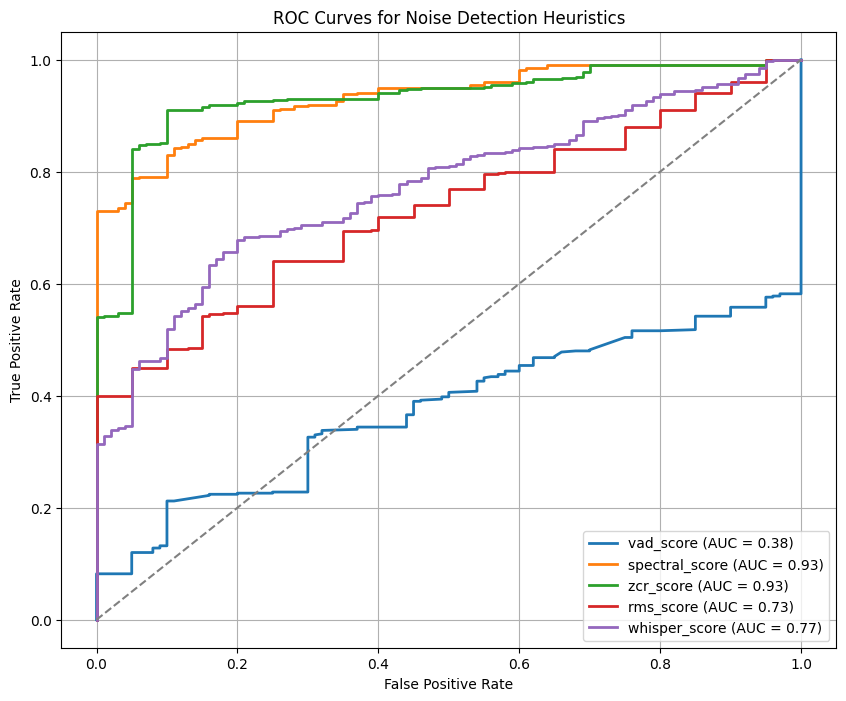

In [12]:
plt.figure(figsize=(10, 8))
for method in ['vad_score', 'spectral_score', 'zcr_score', 'rms_score', 'whisper_score']:
    fpr, tpr, _ = roc_curve(df['is_noisy'], df[method])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{method} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Noise Detection Heuristics')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Conclusion: Interpreting the ROC Curve and Results

The ROC (Receiver Operating Characteristic) curve illustrates the trade-off between the true positive rate (sensitivity) and false positive rate (1 - specificity) across different threshold settings for each detection method. A curve that bows closer to the top-left corner indicates better performance, and the **Area Under the Curve** provides a summary metric of overall effectiveness—values closer to 1.0 indicate strong discriminatory ability, while values near 0.5 suggest no better than random guessing.

In our evaluation, both `zcr_score` (AUC = 0.93) and `spectral_score` (AUC = 0.93) perform very well, indicating that zero-crossing rate and spectral flatness are effective proxies for detecting white noise environments. The `whisper_score` (AUC = 0.77) and `rms_score` (AUC = 0.73) show moderate predictive power, suggesting they provide useful but less decisive signals. In contrast, the `vad_score` performs poorly (AUC = 0.38), implying that voice activity ratio is not a reliable indicator of white noise in this setting—possibly due to VAD misclassifying the absence of structure in white noise as non-speech silence.


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

print("Evaluation by matching # of positive predictions to actual # of noisy samples:\n")

# Group by SNR and compute AUC for each method
methods = ['vad_score', 'spectral_score', 'zcr_score', 'rms_score', 'whisper_score']
results = []
for method in methods:
    # Number of true positives
    n_true_positives = df['is_noisy'].sum()
    print(f"Number of true positives: {n_true_positives}, total: {len(df)}")

    # Rank and predict top-k as noisy
    df_sorted = df.sort_values(method, ascending=False).reset_index(drop=True)
    df_sorted[f'{method}_pred'] = 0
    df_sorted.loc[:n_true_positives-1, f'{method}_pred'] = 1

    # Evaluate
    y_true = df_sorted['is_noisy']
    y_pred = df_sorted[f'{method}_pred']

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    results.append({
        'method': method,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'false_positive_rate': fp / (fp + tn),
        'false_negative_rate': fn / (fn + tp)
    })

# Display as DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values("accuracy", ascending=False)

## Non white noise test

In [23]:
# Select 3 random non-white noise files
non_white_noises = [f for f in NOISE_DIR.glob("*.wav") if "white" not in f.stem.lower()]
selected_noises = sample(non_white_noises, 3)

# Directory to store new mixtures
MIXED_OTHER_DIR = MIXED_DIR / "nonwhite_mixed"
MIXED_OTHER_DIR.mkdir(parents=True, exist_ok=True)

# set log level to warning
logging.basicConfig(level=logging.WARNING)
logging.getLogger('whisper').setLevel(logging.WARNING)

# Mix each with same clean set as before
logging.info("Mixing clean speech with 3 non-white noise files...")
for clean_file in tqdm(clean_files, desc="Mixing non-white noise"):
    for noise_file in selected_noises:
        for snr in SNR_LEVELS:
            out_name = f"{clean_file.stem}_noise_{noise_file.stem}_snr{snr}.wav"
            out_path = MIXED_OTHER_DIR / out_name
            if not out_path.exists():
                mix_with_noise(clean_file, noise_file, snr, out_path)


2025-06-27 18:09:04,777 INFO: Mixing clean speech with 3 non-white noise files...
Mixing non-white noise: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Evaluating non-white noise:   0%|          | 0/360 [00:00<?, ?it/s]

2025-06-27 21:17:34,009 INFO: Processing audio with duration 00:02.125
2025-06-27 21:17:35,834 INFO: Detected language 'en' with probability 0.98
Evaluating non-white noise:   0%|          | 1/360 [00:03<21:21,  3.57s/it]2025-06-27 21:17:37,054 INFO: Processing audio with duration 00:06.455
2025-06-27 21:17:37,504 INFO: Detected language 'en' with probability 0.99
Evaluating non-white noise:   1%|          | 2/360 [00:04<13:33,  2.27s/it]2025-06-27 21:17:38,346 INFO: Processing audio with duration 00:06.550
2025-06-27 21:17:38,782 INFO: Detected language 'en' with probability 1.00
Evaluating non-white noise:   1%|          | 3/360 [00:06<10:55,  1.84s/it]2025-06-27 21:17:39,657 INFO: Processing audio with duration 00:13.930
2025-06-27 21:17:40,066 INFO: Detected language 'en' with probability 1.00
Evaluating non-white noise:   1%|          | 4/360 [00:07<09:54,  1.67s/it]2025-06-27 21:17:41,085 INFO: Processing audio with duration 00:06.730
2025-06-27 21:17:41,499 INFO: Detected langua

df_other:
                                                file  snr  is_noisy  \
0  6829-68771-0026_noise_esc50_2-122763-A-29_snr2...   20     False   
1  5105-28241-0000_noise_esc50_1-39937-A-28_snr0.wav    0      True   
2   61-70970-0028_noise_esc50_1-39937-A-28_snr10.wav   10      True   
3  1188-133604-0019_noise_esc50_1-39937-A-28_snr2...   20     False   
4  1089-134686-0008_noise_esc50_1-39937-A-28_snr2...   20     False   

   vad_score  spectral_score  zcr_score  rms_score  whisper_score  
0   0.071429        0.061792   0.209014   0.043125       0.328194  
1   0.000000        0.051256   0.147434   0.047083       0.459467  
2   0.009174        0.043932   0.127961   0.061364       0.234476  
3   0.262931        0.032338   0.105108   0.043424       0.265934  
4   0.142857        0.038000   0.121066   0.032269       0.269603  
--------------------------------


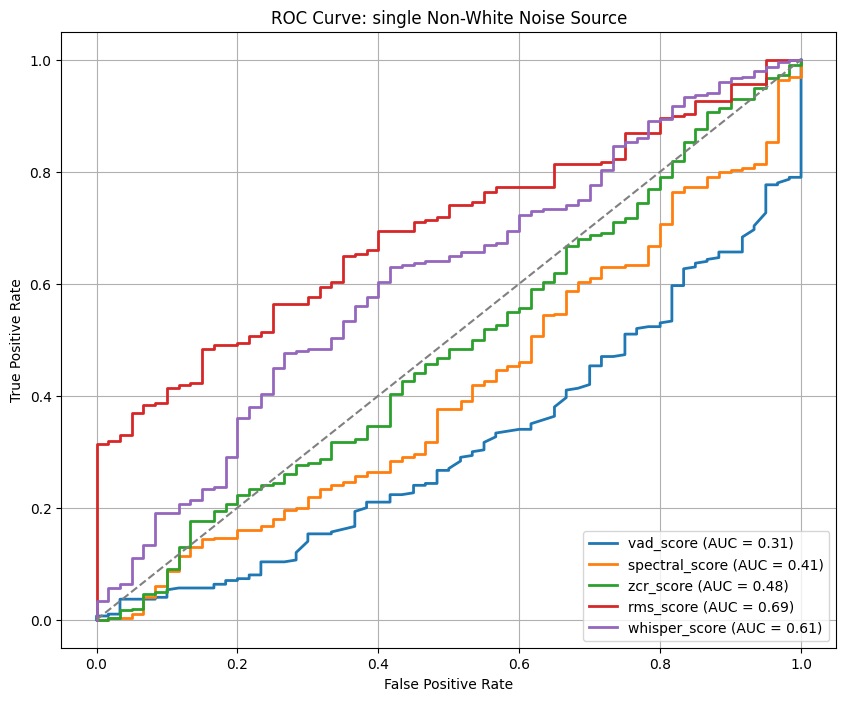

In [35]:

# Evaluate those mixed files
records_other = []

for wav_file in tqdm(list(MIXED_OTHER_DIR.glob("*.wav")), desc='Evaluating non-white noise'):
    snr_value = int(wav_file.stem.split('snr')[-1])
    is_noisy = snr_value < 20

    audio, sr = sf.read(wav_file)
    speech_ratio = run_vad(audio, sr)
    zcr, sfm = compute_spectral_features(audio)
    rms_val = compute_rms(audio)
    conf = whisper_confidence(wav_file)

    records_other.append({
        'file': wav_file.name,
        'snr': snr_value,
        'is_noisy': is_noisy,
        'vad_score': 1 - speech_ratio,
        'spectral_score': sfm,
        'zcr_score': zcr,
        'rms_score': rms_val,
        'whisper_score': -conf
    }) # higher score means more confident in noisy environment

df_other = pd.DataFrame(records_other)
print("df_other:")
print(df_other.head())
print("--------------------------------")

# Plot ROC curve
plt.figure(figsize=(10, 8))
for method in methods:
    fpr, tpr, _ = roc_curve(df_other['is_noisy'], df_other[method])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{method} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: single Non-White Noise Source')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Mix three noise together

In [30]:
# Select all non-white noise candidates
non_white_noises = [f for f in NOISE_DIR.glob("*.wav") if "white" not in f.stem.lower()]

# Output directory
MIXED_3_OTHER_DIR = MIXED_DIR / "nonwhite_3_mixed"
MIXED_3_OTHER_DIR.mkdir(parents=True, exist_ok=True)

logging.info("Mixing clean speech with 3 parallel non-white noise sources (same noise across SNRs)...")
for clean_file in tqdm(clean_files, desc="Mixing non-white noise"):
    
    # Fixed 3 noise files per clean file
    selected_noises = sample(non_white_noises, 3)

    # Load and determine max noise length
    noises = []
    max_len = 0
    for nf in selected_noises:
        noise, _ = sf.read(nf)
        noises.append(noise)
        max_len = max(max_len, len(noise))

    # Pad noises and merge in parallel
    padded_noises = []
    for noise in noises:
        if len(noise) < max_len:
            noise = np.pad(noise, (0, max_len - len(noise)), mode='constant')
        padded_noises.append(noise)

    # Combine and normalize the merged noise
    merged_noise = np.sum(padded_noises, axis=0)
    merged_noise = merged_noise / (np.max(np.abs(merged_noise)) + 1e-8)

    # Load clean signal
    clean, sr = sf.read(clean_file)

    # Repeat noise if too short
    if len(merged_noise) < len(clean):
        repeats = int(np.ceil(len(clean) / len(merged_noise)))
        merged_noise = np.tile(merged_noise, repeats)
    merged_noise = merged_noise[:len(clean)]

    # Loop over SNR levels, reuse the same noise
    for snr in SNR_LEVELS:
        scaled_noise = scale_noise(clean, merged_noise, snr)
        mixture = clean + scaled_noise

        out_name = f"{clean_file.stem}_nonwhite3_snr{snr}.wav"
        out_path = MIXED_3_OTHER_DIR / out_name
        if not out_path.exists():
            sf.write(out_path, mixture, sr)

2025-06-27 18:27:25,506 INFO: Mixing clean speech with 3 parallel non-white noise sources (same noise across SNRs)...
Mixing non-white noise: 100%|██████████| 20/20 [00:00<00:00, 56.91it/s]


In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import soundfile as sf
from tqdm import tqdm

def evaluate_mixed_directory(mixed_dir: Path, methods: list = None) -> pd.DataFrame:
    """
    Evaluate all audio files in a mixed directory using all heuristics.

    Args:
        mixed_dir (Path): Directory containing mixed .wav files
        methods (list): Optional list of method names for scoring

    Returns:
        pd.DataFrame: with columns: file, snr, is_noisy, <method scores>
    """
    records = []
    files = list(mixed_dir.glob("*.wav"))

    if not files:
        print(f"No .wav files found in {mixed_dir}")
        return pd.DataFrame()

    for wav_file in tqdm(files, desc=f"Evaluating {mixed_dir.name}"):
        try:
            snr_value = int(wav_file.stem.split("snr")[-1])
        except Exception:
            print(f"Warning: Could not parse SNR from {wav_file.name}")
            continue

        is_noisy = snr_value < 20
        audio, sr = sf.read(wav_file)

        speech_ratio = run_vad(audio, sr)
        zcr, sfm = compute_spectral_features(audio)
        rms_val = compute_rms(audio)
        conf = whisper_confidence(wav_file)

        records.append({
            'file': wav_file.name,
            'snr': snr_value,
            'is_noisy': is_noisy,
            'vad_score': 1 - speech_ratio,
            'spectral_score': sfm,
            'zcr_score': zcr,
            'rms_score': rms_val,
            'whisper_score': -conf
        })

    df = pd.DataFrame(records)
    return df


def plot_roc_curve(df: pd.DataFrame, title: str = "ROC Curve", methods: list = None, output_dir: Path = None):
    """
    Plot and save ROC curves for the given evaluation DataFrame.

    Args:
        df (pd.DataFrame): must include 'is_noisy' and method score columns
        title (str): Plot title
        methods (list): Optional list of methods to include
        output_dir (Path): Optional folder to save plot as 'roc.png'
    """
    if methods is None:
        methods = [col for col in df.columns if col.endswith('_score')]

    plt.figure(figsize=(10, 8))
    for method in methods:
        try:
            fpr, tpr, _ = roc_curve(df['is_noisy'], df[method])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{method} (AUC = {roc_auc:.2f})')
        except Exception as e:
            print(f"Skipping {method}: {e}")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)

    # Save figure if output_dir is provided
    if output_dir is not None:
        roc_dir = output_dir / "roc"
        roc_dir.mkdir(parents=True, exist_ok=True)
        save_path = roc_dir / "roc.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"ROC curve saved to: {save_path}")

    plt.show()

Evaluating nonwhite_3_mixed:   0%|          | 0/120 [00:00<?, ?it/s]2025-06-27 18:30:11,230 INFO: Processing audio with duration 00:05.685
2025-06-27 18:30:12,696 INFO: Detected language 'en' with probability 0.99
Evaluating nonwhite_3_mixed:   1%|          | 1/120 [00:05<10:03,  5.07s/it]2025-06-27 18:30:15,934 INFO: Processing audio with duration 00:03.075
2025-06-27 18:30:16,405 INFO: Detected language 'en' with probability 0.99
Evaluating nonwhite_3_mixed:   2%|▏         | 2/120 [00:06<05:38,  2.87s/it]2025-06-27 18:30:17,132 INFO: Processing audio with duration 00:05.025
2025-06-27 18:30:17,574 INFO: Detected language 'en' with probability 0.96
Evaluating nonwhite_3_mixed:   2%|▎         | 3/120 [00:07<04:05,  2.10s/it]2025-06-27 18:30:18,328 INFO: Processing audio with duration 00:19.000
2025-06-27 18:30:18,739 INFO: Detected language 'en' with probability 0.98
Evaluating nonwhite_3_mixed:   3%|▎         | 4/120 [00:09<03:53,  2.01s/it]2025-06-27 18:30:20,263 INFO: Processing aud

ROC curve saved to: data/mixed/nonwhite_3_mixed/roc/roc.png


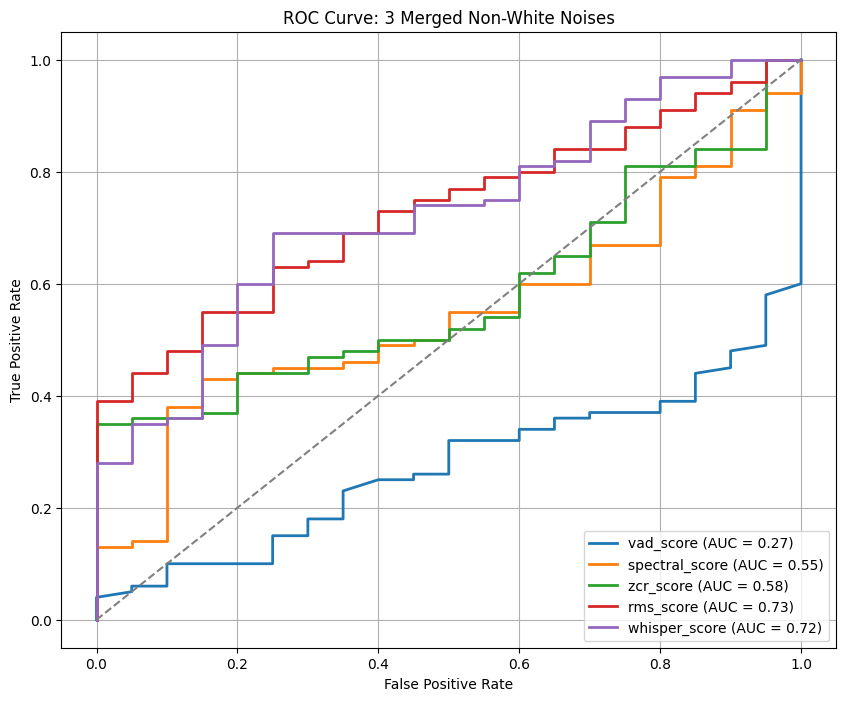

In [33]:
df_nonwhite3 = evaluate_mixed_directory(MIXED_3_OTHER_DIR)
plot_roc_curve(df_nonwhite3, title="ROC Curve: 3 Merged Non-White Noises", output_dir=MIXED_3_OTHER_DIR)